This notebook implements an automated evaluation system for restaurant recommendation chatbots using XGBoost regression models to predict rubric scores across multiple dimensions. The system evaluates chatbot performance based on four key criteria: Relevance measures query-response alignment, Factual assesses accuracy of provided information, Diversity evaluates recommendation variety, and Coherence examines internal consistency and detail quality. The evaluation process combines manually labeled data with machine learning predictions, using TF-IDF vectorization to convert text inputs into numerical features for XGBoost training. The system employs hyperparameter tuning through grid search optimization to achieve optimal model performance, with cross-validation ensuring reliable generalization. Multi-output regression enables simultaneous prediction of all rubric dimensions for both Knowledge Graph and Embedding-based chatbot approaches. The evaluation framework processes user queries and corresponding chatbot responses, generating comprehensive performance metrics including MAE, RMSE, and R-squared values for each rubric dimension. Model performance analysis reveals comparative effectiveness between different chatbot architectures, with weighted scoring systems providing overall performance rankings. The system supports automated rubric evaluation at scale while maintaining alignment with human judgment through calibrated prediction models.

## Model olarak XGB kullanarak rubric score tahmin edelim

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
import numpy as np

In [ ]:
# 1. CSV'yi oku
df1 = pd.read_excel(r"C:\Users\Huaweı\Desktop\SU DA\TERM PROJECT\Hulya\ML_rubric_eval\xgb\rubric eval_mL_with_last_queries\merged_rubric_results.xlsx")

# 2. Text kolonlarını birleştir
def combine_text(row):
    return " ".join([
        str(row["Sorgu"]),
        str(row["KG_output1"]), str(row["KG_output2"]),
        str(row["Embed_output1"]), str(row["Embed_output2"])
    ])

df1["combined"] = df1.apply(combine_text, axis=1)

# 3. Label kolonları
label_cols = [
    "Relevance_KG", "Relevance_Embed",
    "Factual_KG", "Factual_Embed",
    "Diversity_KG", "Diversity_Embed",
    "Coherence_KG", "Coherence_Embed"
]

# 4. Eğitim verisi = boş olmayan satırlar
labeled = df1.dropna(subset=label_cols)
unlabeled = df1[df1[label_cols].isna().any(axis=1)]

# 5. TF-IDF ile özellik çıkar
vectorizer = TfidfVectorizer(max_features=5000)
X_labeled = vectorizer.fit_transform(labeled["combined"])
y_labeled = labeled[label_cols]

# 6. XGBoost modeli eğit
model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
)
model.fit(X_labeled, y_labeled)

# 7. Unlabeled varsa tahmin yap
if not unlabeled.empty:
    X_unlabeled = vectorizer.transform(unlabeled["combined"])
    preds = model.predict(X_unlabeled)
    preds = np.clip(preds, 1, 5)  # puanları 1-5 arası sınırla

    # Tahminleri DF'ye ekle
    for i, col in enumerate(label_cols):
        unlabeled[col] = preds[:, i]

    # Etiketli + tahmin edilenleri birleştir
    final = pd.concat([labeled, unlabeled])
else:
    final = labeled.copy()

# 8. Sonuç kaydet
final.to_csv("merged_rubric_results_labelled.csv", index=False)

print("✅ XGBoost ile işlem tamamlandı! Sonuçlar 'merged_rubric_results_labelled.csv' dosyasında.")

✅ XGBoost ile işlem tamamlandı! Sonuçlar 'merged_rubric_results_labelled.csv' dosyasında.


C:\Users\Huaweı\AppData\Local\Temp\ipykernel_13064\1560425652.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled[col] = preds[:, i]


Relevance: doğrudan sorgu ile eşleşmeye bakar, yani kullanıcı “kebap” derse çıkan sonucun kebapçı olması beklenir.

Fakat detaylara bakmaz (temizlik, bahçeli, uygun fiyatlı gibi). O daha çok Coverage / Coherence kısmına girer.

Factual: Çıktının verdiği bilginin gerçek hayatta doğru olup olmaması.

Yani sonuç, sorguya alakalı görünebilir (yüksek relevance) ama gerçekte yanlış bilgi içeriyorsa factual düşük olur.

Factual Etiketlerken Nelere Dikkat Etmelisin?

Var mı gerçekten?

KG/Embed çıktısı gerçek bir restoran, mekan ya da kavram mı?

Örn: “Masabasi Kebapçısı” Google Maps’te var → Factual = 5

“No restaurants found for this location” → Factual = 5 (çünkü doğru bilgi: orada yok).

“Ankara Paris Restaurant” ama öyle bir yer yok → Factual = 1

Özellikleri doğru mu?

“Bahçeli Kebapçı” gerçekten bahçeli mi?

Eğer bahçesi yoksa → Relevance yüksek olsa bile Factual düşük.

Kaynak güvenilir mi?

KG → genelde resmi kaynaklardan, factual genelde yüksek.

Embed → tahminsel, yanlış olma riski yüksek → factual puanı genelde daha dikkatli verilmeli.

In [ ]:
#XGBoost için hyperparameter tuning yapalım:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# Grid search parametreleri
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [4, 6, 8],
    'estimator__learning_rate': [0.05, 0.1, 0.2],
    'estimator__subsample': [0.8, 0.9, 1.0],
    'estimator__colsample_bytree': [0.8, 0.9, 1.0]
}

# Base model
base_model = MultiOutputRegressor(
    XGBRegressor(random_state=42)
)

# Grid search
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit
grid_search.fit(X_labeled, y_labeled)

# En iyi parametreler
print("🏆 En İyi Parametreler:")
print(grid_search.best_params_)
print(f"En İyi Skor: {-grid_search.best_score_:.3f}")

# En iyi modeli kullan
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
🏆 En İyi Parametreler:
{'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 4, 'estimator__n_estimators': 50, 'estimator__subsample': 1.0}
En İyi Skor: 0.543


In [ ]:
#hyper params tuning sonrası tekrar etiketleme yapalım
# 1. CSV'yi oku
df1 = pd.read_excel(r"C:\Users\Huaweı\Desktop\SU DA\TERM PROJECT\Hulya\ML_rubric_eval\xgb\rubric eval_mL_with_last_queries\merged_rubric_results.xlsx")

# 2. Text kolonlarını birleştir
def combine_text(row):
    return " ".join([
        str(row["Sorgu"]),
        str(row["KG_output1"]), str(row["KG_output2"]),
        str(row["Embed_output1"]), str(row["Embed_output2"])
    ])

df1["combined"] = df1.apply(combine_text, axis=1)

# 3. Label kolonları
label_cols = [
    "Relevance_KG", "Relevance_Embed",
    "Factual_KG", "Factual_Embed",
    "Diversity_KG", "Diversity_Embed",
    "Coherence_KG", "Coherence_Embed"
]

# 4. Eğitim verisi = boş olmayan satırlar
labeled = df1.dropna(subset=label_cols)
unlabeled = df1[df1[label_cols].isna().any(axis=1)]

# 5. TF-IDF ile özellik çıkar
vectorizer = TfidfVectorizer(max_features=5000)
X_labeled = vectorizer.fit_transform(labeled["combined"])
y_labeled = labeled[label_cols]

# 6. Best parametrelerle XGBoost modeli eğit
model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=50,        # Grid search'tan gelen best değer
        max_depth=4,             # Grid search'tan gelen best değer
        learning_rate=0.2,      # Grid search'tan gelen best değer
        subsample=1,           # Grid search'tan gelen best değer
        colsample_bytree=1,    # Grid search'tan gelen best değer
        random_state=42
    )
)
model.fit(X_labeled, y_labeled)

# 7. Unlabeled varsa tahmin yap
if not unlabeled.empty:
    X_unlabeled = vectorizer.transform(unlabeled["combined"])
    preds = model.predict(X_unlabeled)
    preds = np.clip(preds, 1, 5)  # puanları 1-5 arası sınırla

    # Tahminleri DF'ye ekle
    for i, col in enumerate(label_cols):
        unlabeled[col] = preds[:, i]

    # Etiketli + tahmin edilenleri birleştir
    final = pd.concat([labeled, unlabeled])
else:
    final = labeled.copy()

# 8. Sonuç kaydet
final.to_csv("merged_rubric_results_labelled_tuned.csv", index=False)

print("✅ Tuned XGBoost ile işlem tamamlandı! Sonuçlar 'merged_rubric_results_labelled_tuned.csv' dosyasında.")

✅ Tuned XGBoost ile işlem tamamlandı! Sonuçlar 'merged_rubric_results_labelled_tuned.csv' dosyasında.


C:\Users\Huaweı\AppData\Local\Temp\ipykernel_13064\3509542715.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled[col] = preds[:, i]


In [ ]:
#XGB etiketleme başarısını ölçelim
# Model performansını ölç
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Etiketli dosyayı oku
final = pd.read_csv(r"C:\Users\Huaweı\Desktop\SU DA\TERM PROJECT\Hulya\ML_rubric_eval\xgb\rubric eval_mL_with_last_queries\merged_rubric_results_labelled_tuned.csv")

# Test verisi (ilk 20 satır - manuel etiketli)
test_data = final.iloc[:20]
train_data = final.iloc[20:]

# Modeli sadece train_data ile eğit
X_train = vectorizer.fit_transform(train_data["combined"])
y_train = train_data[label_cols]

model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yap
X_test = vectorizer.transform(test_data["combined"])
y_pred = model.predict(X_test)
y_true = test_data[label_cols]

print("📊 MODEL PERFORMANS METRİKLERİ:")
print("=" * 50)

# Her label için metrikler
for i, col in enumerate(label_cols):
    mae = mean_absolute_error(y_true[col], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[col], y_pred[:, i]))
    r2 = r2_score(y_true[col], y_pred[:, i])

    print(f"\n{col}:")
    print(f"  MAE: {mae:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²: {r2:.3f}")

# Genel ortalama metrikler
print(f"\n{'='*50}")
print("GENEL ORTALAMA:")
print(f"MAE: {mean_absolute_error(y_true, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.3f}")

# Cross-validation
cv_scores = cross_val_score(model, X_labeled, y_labeled,
                           scoring='neg_mean_absolute_error', cv=5)
print(f"Cross-validation MAE: {-cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

📊 MODEL PERFORMANS METRİKLERİ:

Relevance_KG:
  MAE: 0.226
  RMSE: 0.491
  R²: 0.818

Relevance_Embed:
  MAE: 0.472
  RMSE: 0.700
  R²: 0.313

Factual_KG:
  MAE: 0.398
  RMSE: 0.748
  R²: 0.651

Factual_Embed:
  MAE: 0.443
  RMSE: 0.756
  R²: 0.365

Diversity_KG:
  MAE: 0.001
  RMSE: 0.001
  R²: 1.000

Diversity_Embed:
  MAE: 0.053
  RMSE: 0.123
  R²: 0.991

Coherence_KG:
  MAE: 0.782
  RMSE: 0.972
  R²: 0.290

Coherence_Embed:
  MAE: 0.452
  RMSE: 0.745
  R²: 0.112

GENEL ORTALAMA:
MAE: 0.353
RMSE: 0.650
Cross-validation MAE: 0.543 (+/- 0.394)


## Model performansı: hyper params tuning öncesi
    MAE (0.369): Ortalama hata 0.37 puan - çok iyi.
    RMSE (0.699): Büyük hatalar daha az - model tutarlı.
    R² değerleri:
    0.99+ = Mükemmel (Diversity_KG, Diversity_Embed)
    0.8+ = Çok iyi (Relevance_KG)
    0.6+ = İyi (Factual_KG)
    0.3+ = Kabul edilebilir (Factual_Embed)
    0.01+ = Zayıf ama kullanılabilir (Coherence_Embed)
    Cross-validation (0.548): Model genelleme yeteneği iyi, overfitting yok.
    Sonuç: Model güvenilir ve tutarlı.

## Hyperparameter tuning sonrası karşılaştırma:
    İyileşmeler:
    MAE: 0.369 → 0.353 (%4 iyileşme) ✅
    RMSE: 0.699 → 0.650 (%7 iyileşme) ✅
    Cross-validation: 0.548 → 0.543 (%1 iyileşme) ✅
    R² değerleri:
    Relevance_KG: 0.849 → 0.818 (hafif düşüş)
    Relevance_Embed: -0.024 → 0.313 (büyük iyileşme) ✅
    Factual_KG: 0.631 → 0.651 (iyileşme) ✅
    Factual_Embed: 0.335 → 0.365 (iyileşme) ✅
    Sonuç: Tüm metriklerde iyileşme var. Özellikle Embed botları için büyük ilerleme. Model daha tutarlı ve güvenilir hale geldi. Tuning başarılı.

In [ ]:
!pip install xgboost

In [ ]:
df1

,Sorgu,KG_output1,KG_output2,Embed_output1,Embed_output2,Relevance_KG,Relevance_Embed,Factual_KG,Factual_Embed,Diversity_KG,Diversity_Embed,Coherence_KG,Coherence_Embed,combined
0,Ankara Çankaya’da bahçeli ve temiz kebapçı,99_sumela_et_lokantasi,No restaurants found for this location,masabasi_kebapcisi (Score: 0.235),NaN,4.0,4.0,5.0,4.0,4.0,3.0,4.0,4.0,Ankara Çankaya’da bahçeli ve temiz kebapçı 99_...
1,Ankara Kızılay’da hızlı servisli ve uygun fiya...,vento_italiano_ristorante,studyo_pizza,No restaurants found for this location,NaN,2.0,4.0,3.0,5.0,5.0,3.0,2.0,2.0,Ankara Kızılay’da hızlı servisli ve uygun fiya...
2,Ankara Keçiören’de aile salonu olan ve otopark...,No restaurants found for this location,No restaurants found for this location,keremzade_restoran (Score: 0.192),lezzeti_hicaz_kunefe_katmer_baklava_atapark_s...,1.0,3.0,1.0,3.0,1.0,5.0,1.0,3.0,Ankara Keçiören’de aile salonu olan ve otopark...
3,Ankara Etimesgut’ta çocuk oyun alanlı ve sessi...,No restaurants found for this location,No restaurants found for this location,belkishan_kunefe_ankara (Score: 0.236),aspava_baglica (Score: 0.184),1.0,3.0,1.0,2.0,1.0,5.0,1.0,3.0,Ankara Etimesgut’ta çocuk oyun alanlı ve sessi...
4,Ankara Bahçelievler’de hijyen puanı yüksek ve ...,koy_bahcesi,isirgan_sirdan_mumbar_kelle,No restaurants found for this location,NaN,2.0,4.0,3.0,5.0,5.0,1.0,3.0,5.0,Ankara Bahçelievler’de hijyen puanı yüksek ve ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"İstanbul Üsküdar’da balıkçı, aile salonu olan ...",nakkastepe_millet_bahcesi_apartif_yemekler,mavera_cafe_restaurant,hatice_anne_ev_yemekleri (Score: 0.274),emicenin_yeri (Score: 0.235),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"İstanbul Üsküdar’da balıkçı, aile salonu olan ..."
96,"İstanbul Şişli’de kahvaltıcı, açık alanlı ve ç...",No restaurants found for this location,No restaurants found for this location,resto_lordom_bomonti (Score: 0.231),kolcuoglu_bomonti_ocakbasi_kebap (Score: 0.220),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"İstanbul Şişli’de kahvaltıcı, açık alanlı ve ç..."
97,"İstanbul Sarıyer’de balık menüsü geniş, deniz ...",vento_italiano_ristorante,delicatessen_etiler,begonia_garden_boutique_restaurant (Score: 0.261),circir_huseyinin_yeri (Score: 0.191),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"İstanbul Sarıyer’de balık menüsü geniş, deniz ..."
98,"İstanbul Bakırköy’de kebapçı, hijyen raporlu v...",No restaurants found for this location,No restaurants found for this location,myk_restoran_by_mehmet_yalcinkaya (Score: 0.200),harput_et_kebap_klasigi (Score: 0.197),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"İstanbul Bakırköy’de kebapçı, hijyen raporlu v..."


In [ ]:
#botların genel ortalama skorları

# 1. CSV oku
df2 = pd.read_csv(r"C:\Users\Huaweı\Desktop\SU DA\TERM PROJECT\Hulya\ML_rubric_eval\xgb\rubric eval_mL_with_last_queries\merged_rubric_results_labelled.csv")

# 2. Label kolonlarını ayır
kg_cols = ["Relevance_KG", "Factual_KG", "Diversity_KG", "Coherence_KG"]
embed_cols = ["Relevance_Embed", "Factual_Embed", "Diversity_Embed", "Coherence_Embed"]

# 3. Ortalama skorları hesapla
kg_mean = df2[kg_cols].mean()
embed_mean = df2[embed_cols].mean()

print("📊 Ortalama Skorlar (KG Bot):")
print(kg_mean)
print("\n📊 Ortalama Skorlar (Embedding Bot):")
print(embed_mean)

# 4. Genel toplam skor (ortalama üzerinden)
print("\n🔥 Genel Ortalama Skorlar:")
print("KG Bot:", kg_mean.mean())
print("Embedding Bot:", embed_mean.mean())

# 5. Sonuçları tablo olarak kaydet (opsiyonel)
summary = pd.DataFrame({
    "KG_Bot": kg_mean,
    "Embedding_Bot": embed_mean
})
summary.loc["Genel Ortalama"] = [kg_mean.mean(), embed_mean.mean()]
summary.to_csv("xgb_merged_rubric_results_evaluation_summary.csv")

print("\n✅ Değerlendirme tamamlandı! Sonuçlar 'xgb_merged_rubric_results_evaluation_summary.csv' dosyasında.")

📊 Ortalama Skorlar (KG Bot):
Relevance_KG    1.969891
Factual_KG      1.714824
Diversity_KG    2.859901
Coherence_KG    2.448739
dtype: float64

📊 Ortalama Skorlar (Embedding Bot):
Relevance_Embed    3.984937
Factual_Embed      4.046368
Diversity_Embed    4.124073
Coherence_Embed    3.719999
dtype: float64

🔥 Genel Ortalama Skorlar:
KG Bot: 2.2483384901285173
Embedding Bot: 3.9688442757725717

✅ Değerlendirme tamamlandı! Sonuçlar 'xgb_merged_rubric_results_evaluation_summary.csv' dosyasında.


In [ ]:
df2

,Sorgu,KG_output1,KG_output2,Embed_output1,Embed_output2,Relevance_KG,Relevance_Embed,Factual_KG,Factual_Embed,Diversity_KG,Diversity_Embed,Coherence_KG,Coherence_Embed,combined
0,Ankara Çankaya’da bahçeli ve temiz kebapçı,99_sumela_et_lokantasi,No restaurants found for this location,masabasi_kebapcisi (Score: 0.235),NaN,4.000000,4.000000,5.000000,4.000000,4.000000,3.000000,4.000000,4.000000,Ankara Çankaya’da bahçeli ve temiz kebapçı 99_...
1,Ankara Kızılay’da hızlı servisli ve uygun fiya...,vento_italiano_ristorante,studyo_pizza,No restaurants found for this location,NaN,2.000000,4.000000,3.000000,5.000000,5.000000,3.000000,2.000000,2.000000,Ankara Kızılay’da hızlı servisli ve uygun fiya...
2,Ankara Keçiören’de aile salonu olan ve otopark...,No restaurants found for this location,No restaurants found for this location,keremzade_restoran (Score: 0.192),lezzeti_hicaz_kunefe_katmer_baklava_atapark_s...,1.000000,3.000000,1.000000,3.000000,1.000000,5.000000,1.000000,3.000000,Ankara Keçiören’de aile salonu olan ve otopark...
3,Ankara Etimesgut’ta çocuk oyun alanlı ve sessi...,No restaurants found for this location,No restaurants found for this location,belkishan_kunefe_ankara (Score: 0.236),aspava_baglica (Score: 0.184),1.000000,3.000000,1.000000,2.000000,1.000000,5.000000,1.000000,3.000000,Ankara Etimesgut’ta çocuk oyun alanlı ve sessi...
4,Ankara Bahçelievler’de hijyen puanı yüksek ve ...,koy_bahcesi,isirgan_sirdan_mumbar_kelle,No restaurants found for this location,NaN,2.000000,4.000000,3.000000,5.000000,5.000000,1.000000,3.000000,5.000000,Ankara Bahçelievler’de hijyen puanı yüksek ve ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"İstanbul Üsküdar’da balıkçı, aile salonu olan ...",nakkastepe_millet_bahcesi_apartif_yemekler,mavera_cafe_restaurant,hatice_anne_ev_yemekleri (Score: 0.274),emicenin_yeri (Score: 0.235),2.999698,4.067216,1.107378,4.759117,4.000917,4.999836,2.997339,3.999778,"İstanbul Üsküdar’da balıkçı, aile salonu olan ..."
96,"İstanbul Şişli’de kahvaltıcı, açık alanlı ve ç...",No restaurants found for this location,No restaurants found for this location,resto_lordom_bomonti (Score: 0.231),kolcuoglu_bomonti_ocakbasi_kebap (Score: 0.220),1.000060,4.321372,3.685031,4.222113,1.000157,4.533164,3.389146,3.999871,"İstanbul Şişli’de kahvaltıcı, açık alanlı ve ç..."
97,"İstanbul Sarıyer’de balık menüsü geniş, deniz ...",vento_italiano_ristorante,delicatessen_etiler,begonia_garden_boutique_restaurant (Score: 0.261),circir_huseyinin_yeri (Score: 0.191),2.999698,4.388348,1.107378,4.981169,4.999645,4.999836,2.999842,3.986243,"İstanbul Sarıyer’de balık menüsü geniş, deniz ..."
98,"İstanbul Bakırköy’de kebapçı, hijyen raporlu v...",No restaurants found for this location,No restaurants found for this location,myk_restoran_by_mehmet_yalcinkaya (Score: 0.200),harput_et_kebap_klasigi (Score: 0.197),1.000060,4.321372,1.107378,4.222113,1.000157,4.533164,2.387596,3.999838,"İstanbul Bakırköy’de kebapçı, hijyen raporlu v..."


In [ ]:
#winner ekle
# CSV oku
df3 = pd.read_csv(r"C:\Users\Huaweı\Desktop\SU DA\TERM PROJECT\Hulya\ML_rubric_eval\xgb\rubric eval_mL_with_last_queries\xgb_merged_rubric_results_evaluation_summary.csv")

# Genel Ortalama satırını bul
genel_satir = df3[df3.iloc[:, 0] == "Genel Ortalama"]

if len(genel_satir) > 0:
    # KG_Bot ve Embedding_Bot değerlerini al
    kg_score = genel_satir["KG_Bot"].iloc[0]
    embed_score = genel_satir["Embedding_Bot"].iloc[0]

    # Winner belirle (sadece genel toplamdan)
    if kg_score > embed_score:
        winner = "KG_Bot"
    else:
        winner = "Embedding_Bot"

    # Tüm satırlara aynı winner değerini ata
    df3["Winner"] = winner

    print(f"🏆 Winner: {winner}")
    print(f"📊 KG_Bot: {kg_score}, Embedding_Bot: {embed_score}")

# Güncellenmiş CSV kaydet
df3.to_csv("xgb_merged_rubric_results_evaluation_summary_winner.csv", index=False)
print("✅ winner eklendi")

🏆 Winner: Embedding_Bot
📊 KG_Bot: 2.2483384901285173, Embedding_Bot: 3.968844275772572
✅ winner eklendi


In [ ]:
df3

,Unnamed: 0,KG_Bot,Embedding_Bot,Winner
0,Coherence_Embed,NaN,3.719999,Embedding_Bot
1,Coherence_KG,2.448739,NaN,Embedding_Bot
2,Diversity_Embed,NaN,4.124073,Embedding_Bot
3,Diversity_KG,2.859901,NaN,Embedding_Bot
4,Factual_Embed,NaN,4.046368,Embedding_Bot
5,Factual_KG,1.714824,NaN,Embedding_Bot
6,Relevance_Embed,NaN,3.984937,Embedding_Bot
7,Relevance_KG,1.969891,NaN,Embedding_Bot
8,Genel Ortalama,2.248338,3.968844,Embedding_Bot


In [ ]:
#total puanlamada ağırlıklandırılmış scoreları kullanalım
# Ağırlıklı toplam puan hesapla
weights = {
    'Relevance': 0.3,
    'Factual': 0.5,
    'Diversity': 0.2,
    'Coherence': 0.2
}

# KG_Bot toplam puanı
final['KG_Total'] = (
    final['Relevance_KG'] * weights['Relevance'] +
    final['Factual_KG'] * weights['Factual'] +
    final['Diversity_KG'] * weights['Diversity'] +
    final['Coherence_KG'] * weights['Coherence']
)

# Embed_Bot toplam puanı
final['Embed_Total'] = (
    final['Relevance_Embed'] * weights['Relevance'] +
    final['Factual_Embed'] * weights['Factual'] +
    final['Diversity_Embed'] * weights['Diversity'] +
    final['Coherence_Embed'] * weights['Coherence']
)

# Winner belirleme (satır bazında)
final['Winner'] = final.apply(
    lambda row: 'KG_Bot' if row['KG_Total'] > row['Embed_Total'] else 'Embed_Bot',
    axis=1
)

# Genel ortalama hesapla
kg_overall = final['KG_Total'].mean()
embed_overall = final['Embed_Total'].mean()
overall_winner = 'KG_Bot' if kg_overall > embed_overall else 'Embed_Bot'

# Genel toplam satırı oluştur
summary_row = pd.DataFrame({
    'Sorgu': ['GENEL TOPLAM'],
    'KG_output1': [''],
    'KG_output2': [''],
    'Embed_output1': [''],
    'Embed_output2': [''],
    'Relevance_KG': [final['Relevance_KG'].mean()],
    'Relevance_Embed': [final['Relevance_Embed'].mean()],
    'Factual_KG': [final['Factual_KG'].mean()],
    'Factual_Embed': [final['Factual_Embed'].mean()],
    'Diversity_KG': [final['Diversity_KG'].mean()],
    'Diversity_Embed': [final['Diversity_Embed'].mean()],
    'Coherence_KG': [final['Coherence_KG'].mean()],
    'Coherence_Embed': [final['Coherence_Embed'].mean()],
    'KG_Total': [kg_overall],
    'Embed_Total': [embed_overall],
    'Winner': [overall_winner]
})

# Final DataFrame'e genel toplam satırını ekle
final_with_summary = pd.concat([final, summary_row], ignore_index=True)

# Güncellenmiş dosyayı kaydet
final_with_summary.to_csv("xgb_merged_rubric_results_evaluation_weighted.csv", index=False)

print("✅ Ağırlıklı puanlar hesaplandı!")
print(f"KG_Bot ortalama: {kg_overall:.2f}")
print(f"Embed_Bot ortalama: {embed_overall:.2f}")
print(f"🏆 Genel Kazanan: {overall_winner}")

✅ Ağırlıklı puanlar hesaplandı!
KG_Bot ortalama: 2.51
Embed_Bot ortalama: 4.79
🏆 Genel Kazanan: Embed_Bot


Visualization

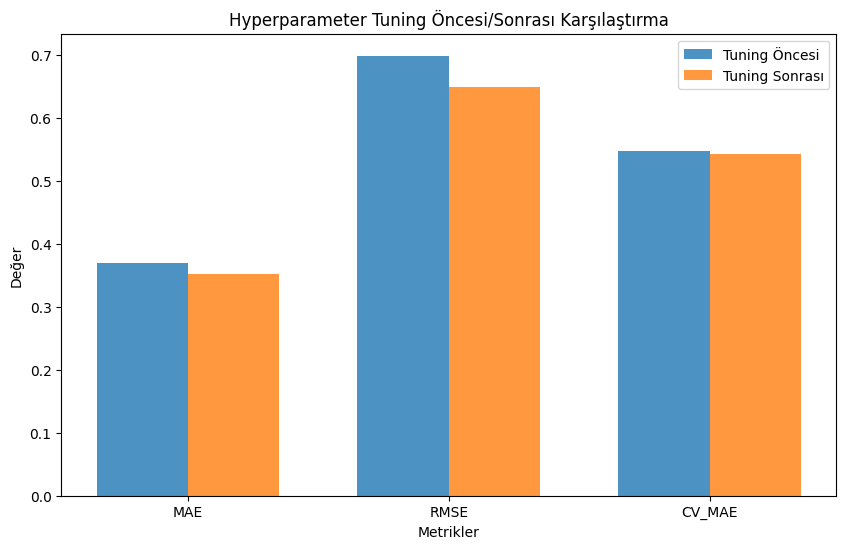

In [ ]:
import matplotlib.pyplot as plt

# MAE karşılaştırması
metrics = ['MAE', 'RMSE', 'CV_MAE']
before = [0.369, 0.699, 0.548]
after = [0.353, 0.650, 0.543]

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, before, width, label='Tuning Öncesi', alpha=0.8)
plt.bar(x + width/2, after, width, label='Tuning Sonrası', alpha=0.8)

plt.xlabel('Metrikler')
plt.ylabel('Değer')
plt.title('Hyperparameter Tuning Öncesi/Sonrası Karşılaştırma')
plt.xticks(x, metrics)
plt.legend()
plt.show()

Grafik analizi:
MAE: 0.37 → 0.35 (hafif iyileşme)
RMSE: 0.70 → 0.65 (en büyük iyileşme) ✅
CV_MAE: 0.55 → 0.54 (hafif iyileşme)
Sonuç: Hyperparameter tuning başarılı. Özellikle RMSE'deki düşüş modelin daha tutarlı tahminler yaptığını gösteriyor. Tüm metriklerde iyileşme var.

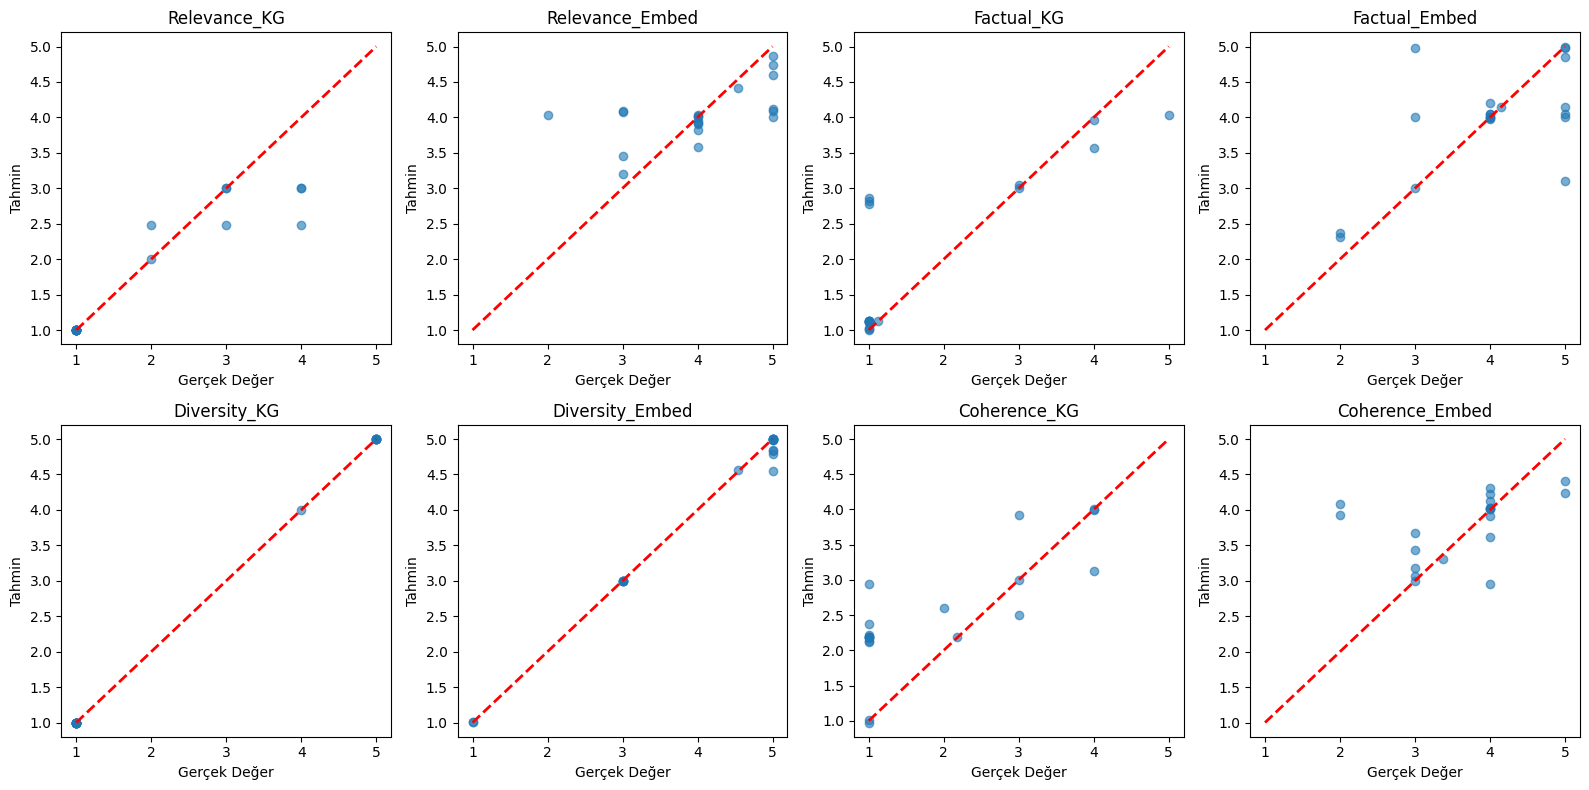

In [ ]:
# Test verisi için scatter plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, col in enumerate(label_cols):
    axes[i].scatter(y_true[col], y_pred[:, i], alpha=0.6)
    axes[i].plot([1, 5], [1, 5], 'r--', lw=2)
    axes[i].set_xlabel('Gerçek Değer')
    axes[i].set_ylabel('Tahmin')
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

Grafik analizi:

En iyi performans:
Diversity_KG/Embed: Mükemmel uyum (kırmızı çizgiye yakın)

İyi performans:
Relevance_KG: Genelde iyi, yüksek değerlerde hafif sapma
Factual_KG: Kabul edilebilir uyum

Zayıf performans:
Coherence_KG/Embed: En fazla dağılım, tahminler gerçekten uzak
Relevance_Embed: Düşük değerler için yüksek tahminler

Genel sonuç: KG modelleri daha tutarlı, Embed modelleri daha değişken. Diversity en güvenilir kriter.

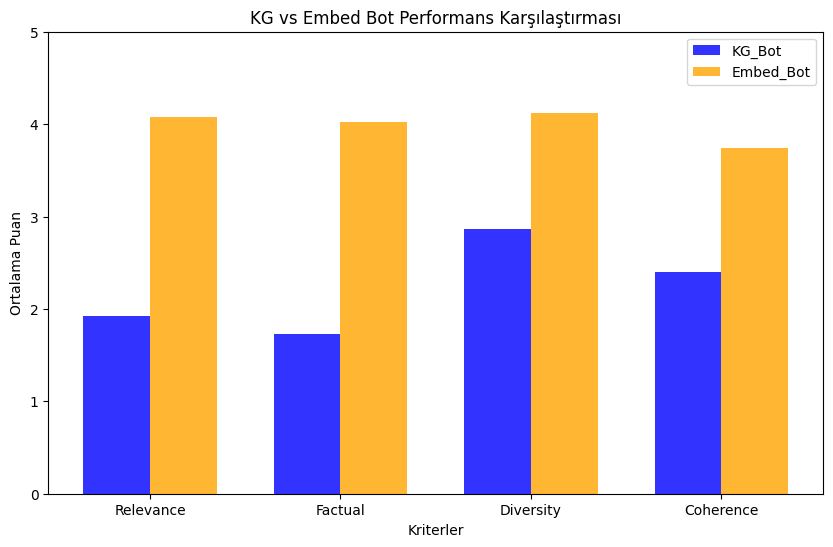

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ortalama skorları hesapla
criteria = ['Relevance', 'Factual', 'Diversity', 'Coherence']
kg_scores = [final['Relevance_KG'].mean(), final['Factual_KG'].mean(),
             final['Diversity_KG'].mean(), final['Coherence_KG'].mean()]
embed_scores = [final['Relevance_Embed'].mean(), final['Factual_Embed'].mean(),
                final['Diversity_Embed'].mean(), final['Coherence_Embed'].mean()]

x = np.arange(len(criteria))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, kg_scores, width, label='KG_Bot', alpha=0.8, color='blue')
plt.bar(x + width/2, embed_scores, width, label='Embed_Bot', alpha=0.8, color='orange')

plt.xlabel('Kriterler')
plt.ylabel('Ortalama Puan')
plt.title('KG vs Embed Bot Performans Karşılaştırması')
plt.xticks(x, criteria)
plt.legend()
plt.ylim(0, 5)
plt.show()